In [67]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import nltk
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [68]:
def extract_pos_words(pos_tagged_content, allowed_pos):
    return [word for word, pos in pos_tagged_content if pos in allowed_pos and word.isalpha()]

df = pd.read_csv('scraped_data_with_ideology.csv')

allowed_pos = {'NOUN', 'ADJ', 'VERB'}


def pos_filter(text):
    allowed_pos = {'NOUN','VERB', 'ADJ'}
    doc = nlp(text)
    words = [token.text.lower() for token in doc if token.pos_ in allowed_pos and token.is_alpha]
    return ' '.join(words)


df['processed_text'] = df['all_text'].apply(pos_filter)


print(df['processed_text'].head())

0    think go big surprise upset election exclude f...
1    cost inability successful complete bipartisans...
2    trump lose form new party rnc beat candidate c...
3    specific feature political system general disa...
4    brass tack time win feel win presidency person...
Name: processed_text, dtype: object


In [69]:
num_topics=15

In [70]:
vectorizer = CountVectorizer(max_features=5000, stop_words='english',min_df=5,max_df = 0.3)
dtm = vectorizer.fit_transform(df['processed_text'])


lda = LatentDirichletAllocation(n_components=num_topics, random_state=42, max_iter=10)
lda.fit(dtm)


# identify top 10 words for all topics
top_words_per_topic = {}
for topic_idx, topic in enumerate(lda.components_):
    top_words_per_topic[topic_idx] = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]

# count how many topics each word appears in
word_count_in_topics = {}
for topic_idx, top_words in top_words_per_topic.items():
    for word in top_words:
        if word not in word_count_in_topics:
            word_count_in_topics[word] = 0
        word_count_in_topics[word] += 1

#exclude words that appear in the top 10 words of more than 3 topics
exclude_threshold = 3
exclude_words_dynamic = [word for word, count in word_count_in_topics.items() if count > exclude_threshold]

# print excluded words
print(f"Excluding words: {exclude_words_dynamic}")

Excluding words: ['campaign', 'people', 'support', 'state', 'vote', 'candidate', 'voter', 'presidential', 'win', 'political']


In [71]:
vectorizer = CountVectorizer(
    max_features=5000, 
    stop_words='english', 
    min_df=5, 
    max_df=0.3,
    vocabulary=[word for word in vectorizer.get_feature_names_out() if word not in exclude_words_dynamic]  # Remove dynamic exclusions
)

dtm = vectorizer.fit_transform(df['processed_text'])

lda = LatentDirichletAllocation(n_components=num_topics, random_state=42, max_iter=10)
lda.fit(dtm)

LatentDirichletAllocation(n_components=15, random_state=42)

In [72]:
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topics[f"Topic {topic_idx+1}"] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return topics

In [73]:
top_words = display_topics(lda, vectorizer.get_feature_names_out(), 10)

topics_df = pd.DataFrame(top_words).T
topics_df.columns = [f"Word {i+1}" for i in range(10)]

topics_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,policy,inflation,issue,debate,voting,biden,right,thing,economy,lot
Topic 2,good,woman,black,man,president,time,thing,year,party,different
Topic 3,abortion,woman,young,ban,right,gender,come,point,man,military
Topic 4,say,threat,war,question,legal,speech,case,new,concern,claim
Topic 5,party,race,polling,poll,lead,time,major,chance,recent,point
Topic 6,party,voting,conservative,ballot,change,view,case,mail,partisan,issue
Topic 7,electoral,college,happen,swing,blue,popular,point,race,red,time
Topic 8,lose,party,democratic,biden,happen,debate,lead,say,nominee,point
Topic 9,policy,tax,plan,law,good,pay,strike,statement,president,country
Topic 10,poll,recall,pollster,endorsement,result,polling,rally,year,right,medium


In [74]:
def get_top_words_per_topic(model, feature_names, num_words=50):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topics[f"Topic {topic_idx+1}"] = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
    return topics


top_50_words = get_top_words_per_topic(lda, vectorizer.get_feature_names_out())


top_50_df = pd.DataFrame(top_50_words).T


top_50_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Topic 1,policy,inflation,issue,debate,voting,biden,right,thing,economy,lot,...,way,bad,tariff,figure,appear,turn,say,immigration,world,count
Topic 2,good,woman,black,man,president,time,thing,year,party,different,...,personal,opinion,donald,increase,politic,age,play,rise,happen,decision
Topic 3,abortion,woman,young,ban,right,gender,come,point,man,military,...,chance,thought,stance,base,republican,majority,party,american,law,response
Topic 4,say,threat,war,question,legal,speech,case,new,concern,claim,...,social,power,hear,ground,real,refuse,court,interview,result,medium
Topic 5,party,race,polling,poll,lead,time,major,chance,recent,point,...,come,significant,percent,left,government,cost,primary,office,consider,high
Topic 6,party,voting,conservative,ballot,change,view,case,mail,partisan,issue,...,specific,happen,house,government,cast,allegation,hate,make,tend,know
Topic 7,electoral,college,happen,swing,blue,popular,point,race,red,time,...,believe,interview,feel,issue,situation,want,seat,speech,hold,process
Topic 8,lose,party,democratic,biden,happen,debate,lead,say,nominee,point,...,man,look,continue,tactic,bring,civil,potential,war,remain,help
Topic 9,policy,tax,plan,law,good,pay,strike,statement,president,country,...,propose,want,rural,believe,turn,taxis,funding,certain,receive,red
Topic 10,poll,recall,pollster,endorsement,result,polling,rally,year,right,medium,...,winner,special,national,change,example,avoid,lose,case,self,day


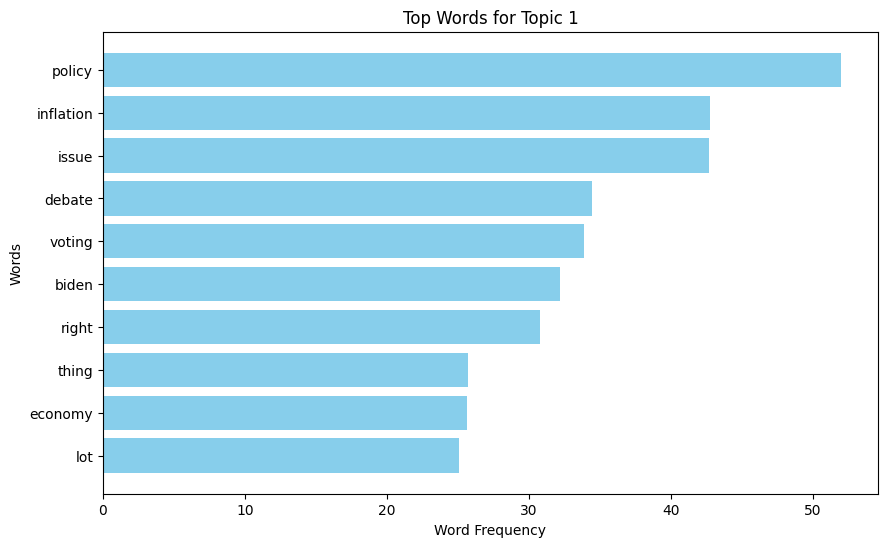

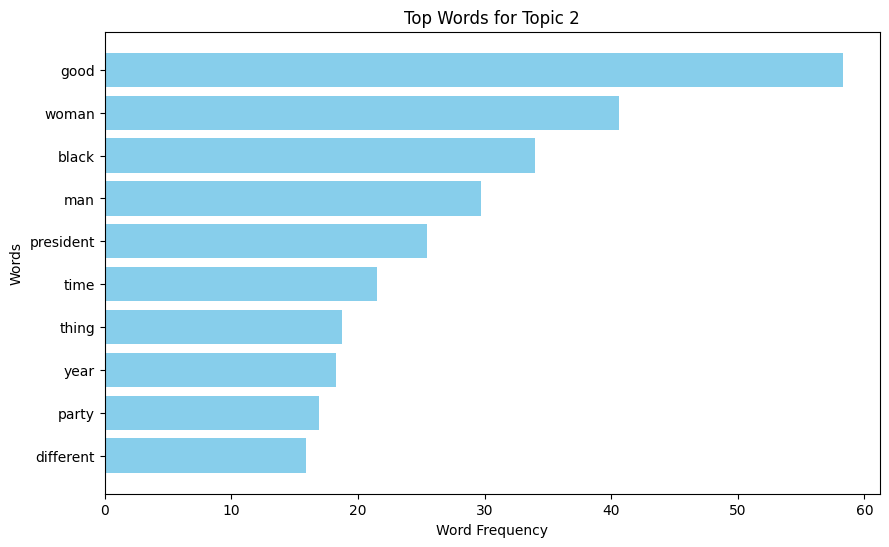

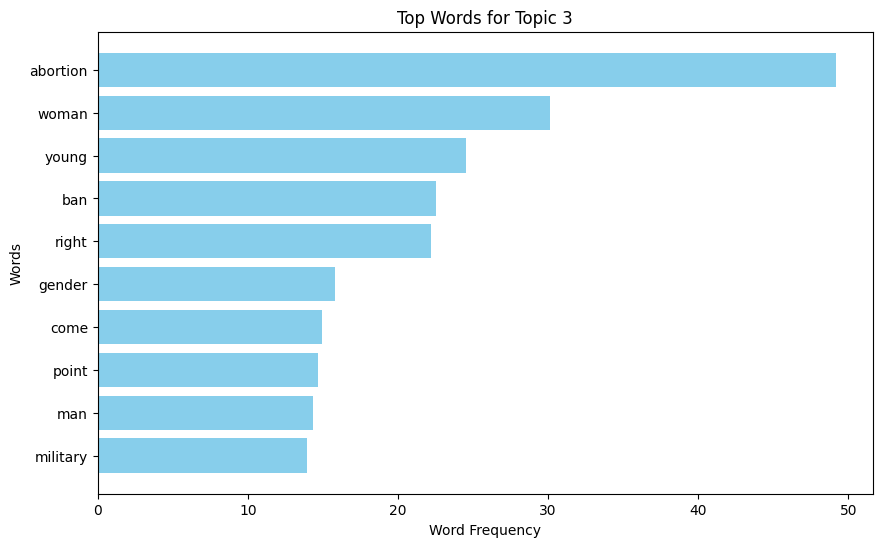

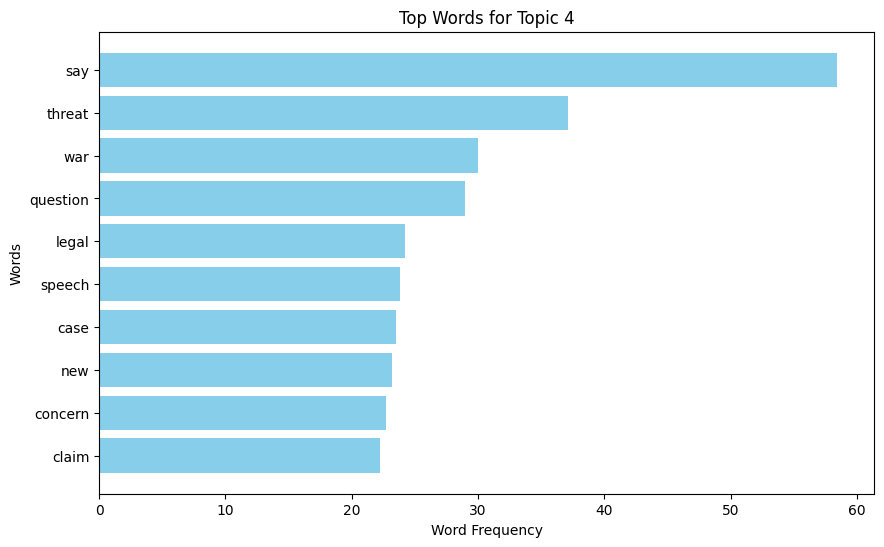

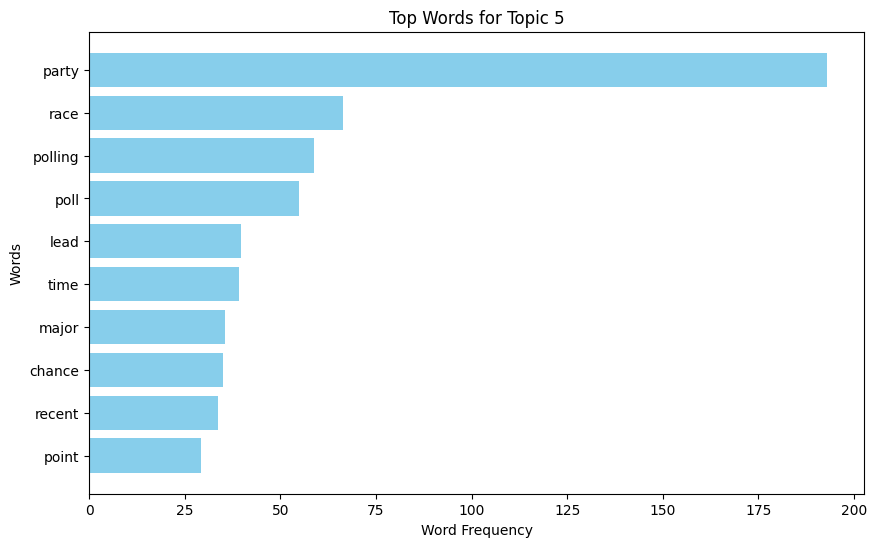

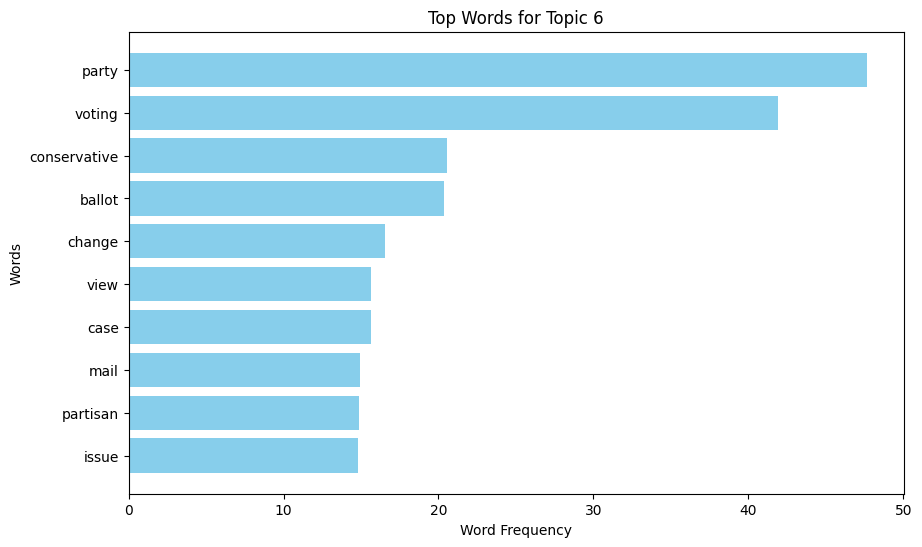

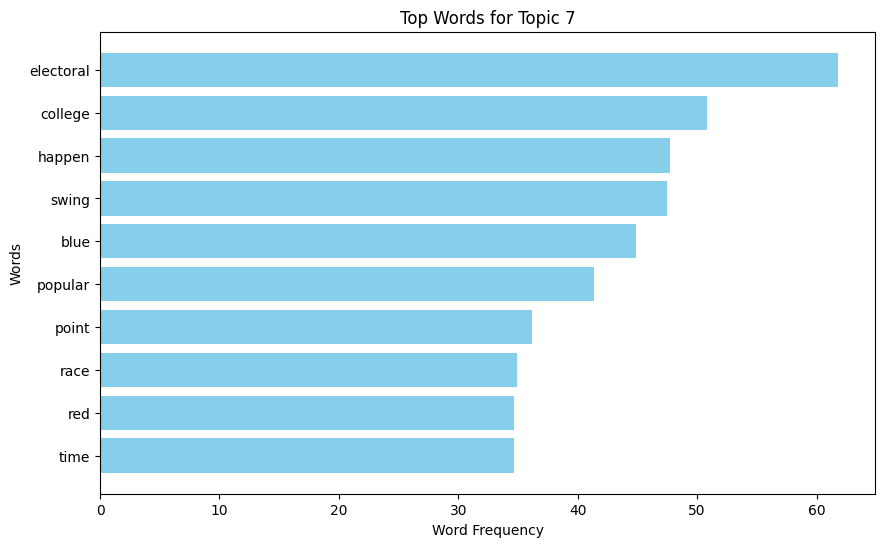

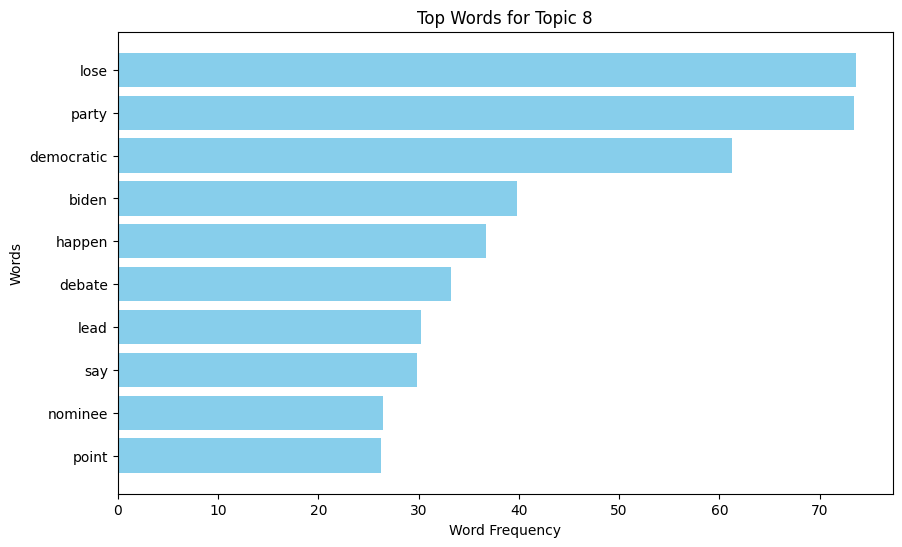

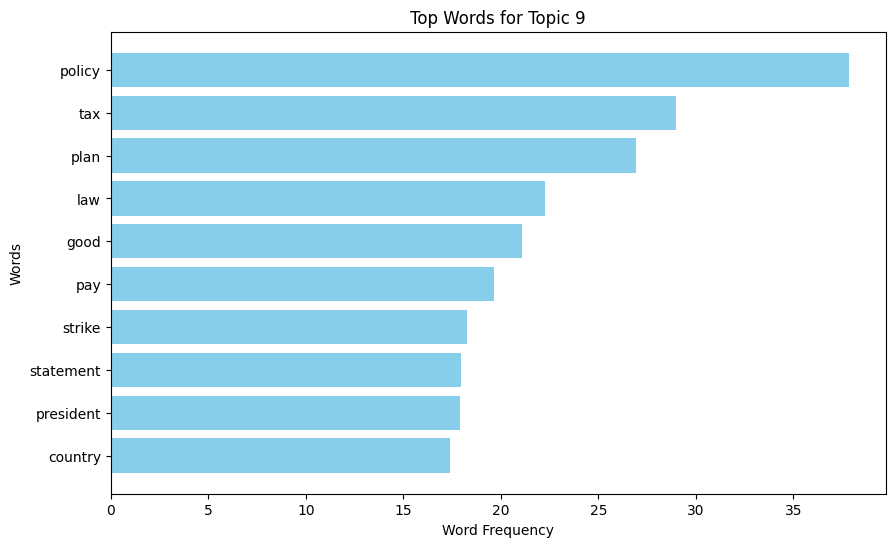

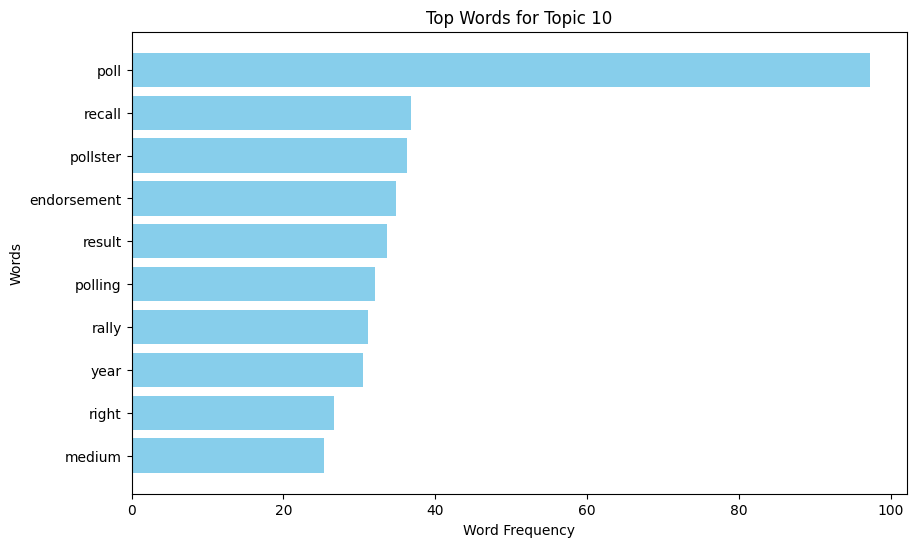

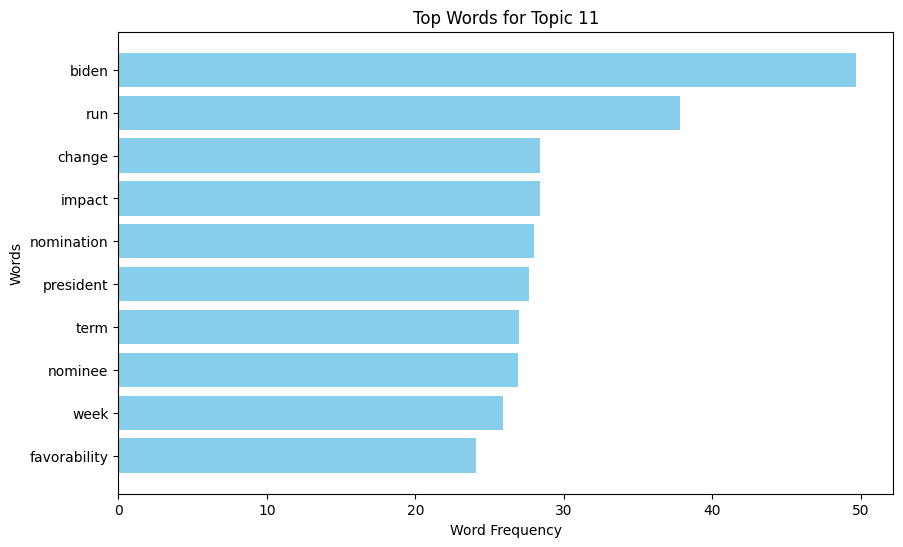

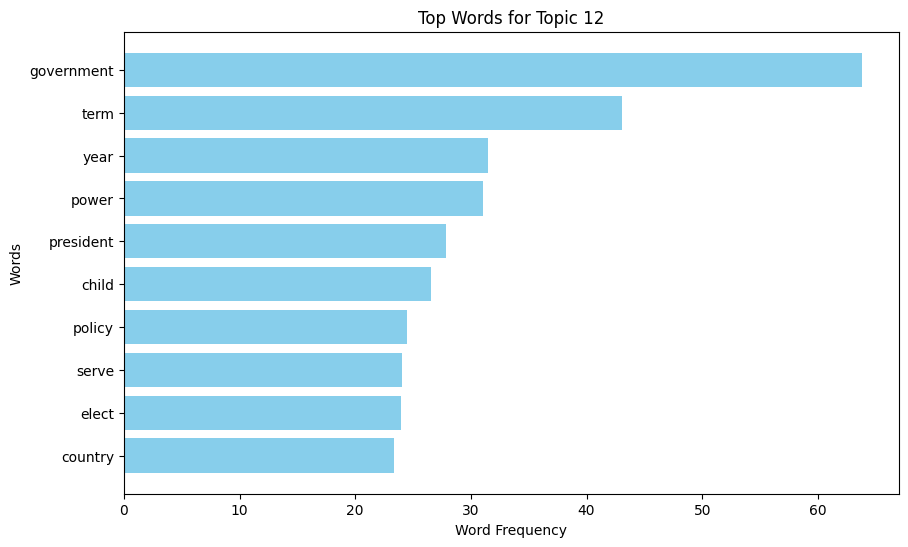

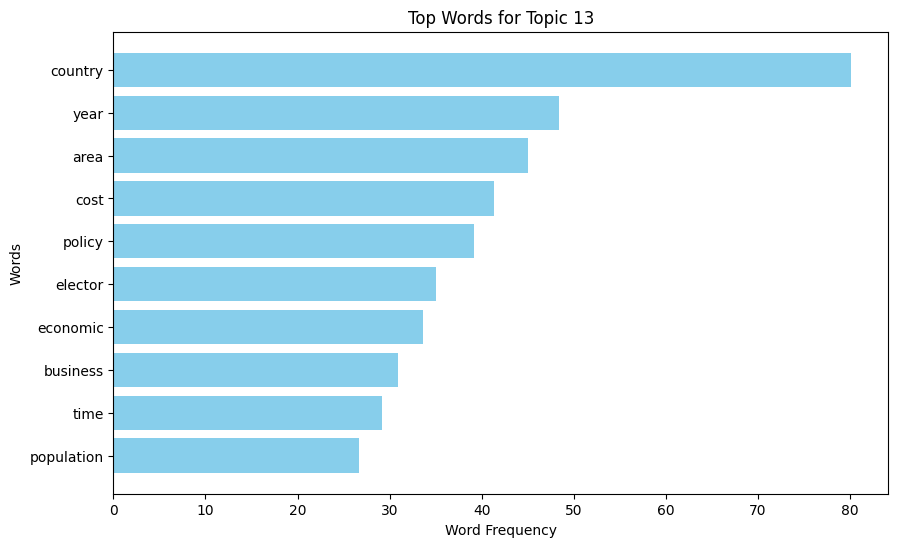

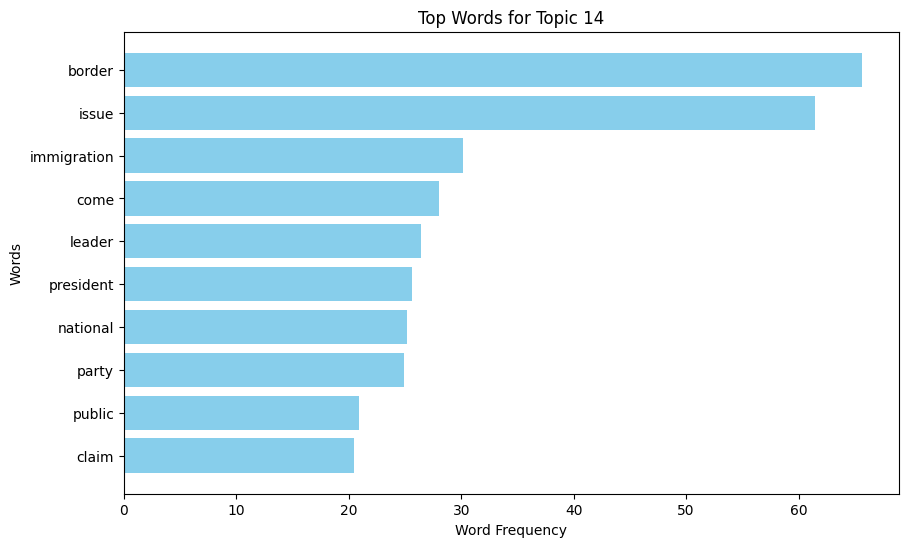

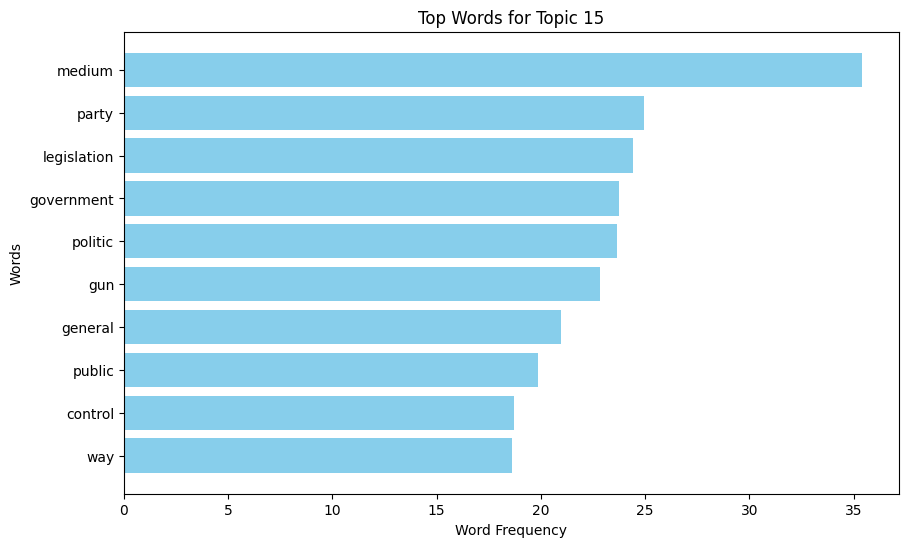

In [75]:
import matplotlib.pyplot as plt

def plot_top_words(topic_words, topic_idx):
    plt.figure(figsize=(10, 6))
    plt.barh(topic_words.index, topic_words.values, color='skyblue')
    plt.gca().invert_yaxis()
    plt.title(f"Top Words for Topic {topic_idx}")
    plt.xlabel("Word Frequency")
    plt.ylabel("Words")
    plt.show()


for i in range(num_topics):
    topic_1_words = pd.Series(lda.components_[i], index=vectorizer.get_feature_names_out()).nlargest(10)
    plot_top_words(topic_1_words, topic_idx=i+1)